# Try to use PiDiNet with the provided checkpoint

In [ ]:
import sys
sys.path.append("../../resource/PiDiNet/pidinet-master")

In [2]:
import models
from models.config import config_model, config_model_converted
from models.pidinet import PiDiNet
import torch

In [3]:
class Args:
    model = "pidinet_converted"
    config = "carv4"
    sa = True
    dil = True

args = Args()
model = getattr(models, args.model)(args)

{'layer0': 'cd', 'layer1': 'ad', 'layer2': 'rd', 'layer3': 'cv', 'layer4': 'cd', 'layer5': 'ad', 'layer6': 'rd', 'layer7': 'cv', 'layer8': 'cd', 'layer9': 'ad', 'layer10': 'rd', 'layer11': 'cv', 'layer12': 'cd', 'layer13': 'ad', 'layer14': 'rd', 'layer15': 'cv'}
initialization done


In [4]:
# pdcs = config_model('carv4')
# pdcs = config_model_converted("carv4")
# model = PiDiNet(60, pdcs, dil=24, sa=True)


In [6]:
# checkpoint = load_checkpoint(args, running_file)
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
from models.convert_pidinet import convert_pidinet

checkpoint = torch.load('../../resource/PiDiNet/pidinet-master/trained_models/table7_pidinet.pth', map_location="cpu", weights_only=True)
# model.load_state_dict(checkpoint['state_dict'])
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
model.load_state_dict(convert_pidinet(state_dict, args.config))


{'layer0': 'cd', 'layer1': 'ad', 'layer2': 'rd', 'layer3': 'cv', 'layer4': 'cd', 'layer5': 'ad', 'layer6': 'rd', 'layer7': 'cv', 'layer8': 'cd', 'layer9': 'ad', 'layer10': 'rd', 'layer11': 'cv', 'layer12': 'cd', 'layer13': 'ad', 'layer14': 'rd', 'layer15': 'cv'}


<All keys matched successfully>

In [7]:
# checkpoint['state_dict'].keys()
convert_pidinet(checkpoint['state_dict'], args.config).keys()

{'layer0': 'cd', 'layer1': 'ad', 'layer2': 'rd', 'layer3': 'cv', 'layer4': 'cd', 'layer5': 'ad', 'layer6': 'rd', 'layer7': 'cv', 'layer8': 'cd', 'layer9': 'ad', 'layer10': 'rd', 'layer11': 'cv', 'layer12': 'cd', 'layer13': 'ad', 'layer14': 'rd', 'layer15': 'cv'}


dict_keys(['module.init_block.weight', 'module.block1_1.conv1.weight', 'module.block1_1.conv2.weight', 'module.block1_2.conv1.weight', 'module.block1_2.conv2.weight', 'module.block1_3.conv1.weight', 'module.block1_3.conv2.weight', 'module.block2_1.shortcut.weight', 'module.block2_1.shortcut.bias', 'module.block2_1.conv1.weight', 'module.block2_1.conv2.weight', 'module.block2_2.conv1.weight', 'module.block2_2.conv2.weight', 'module.block2_3.conv1.weight', 'module.block2_3.conv2.weight', 'module.block2_4.conv1.weight', 'module.block2_4.conv2.weight', 'module.block3_1.shortcut.weight', 'module.block3_1.shortcut.bias', 'module.block3_1.conv1.weight', 'module.block3_1.conv2.weight', 'module.block3_2.conv1.weight', 'module.block3_2.conv2.weight', 'module.block3_3.conv1.weight', 'module.block3_3.conv2.weight', 'module.block3_4.conv1.weight', 'module.block3_4.conv2.weight', 'module.block4_1.shortcut.weight', 'module.block4_1.shortcut.bias', 'module.block4_1.conv1.weight', 'module.block4_1.conv

# 推理

In [8]:
import torch
import numpy as np
from torch.utils.data.dataset import Dataset
from pathlib import Path
from PIL import Image
import torchvision.transforms as transforms

class BIPEDv2(Dataset):
    def __init__(self, ori_path, gt_path):
        self.ori_path = Path(ori_path)
        self.gt_path = Path(gt_path)
        self.indexes = list(set([x.stem for x in self.ori_path.iterdir() if not x.name.startswith(".")]) & set([x.stem for x in self.gt_path.iterdir() if not x.name.startswith(".")]))
        self.indexes = np.sort(self.indexes)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            normalize])

    def __len__(self):
        return len(self.indexes)
    
    def __getitem__(self, i):
        x = Image.open(self.ori_path.joinpath(self.indexes[i]).with_suffix(".jpg")).convert('RGB')
        # denom = 255 if x.max() > 1 else 1
        y = Image.open(self.gt_path.joinpath(self.indexes[i]).with_suffix(".png"))# .convert('RGB')

        x, y = self.transform(x), np.array(y) / 255
        
        return x, y

In [10]:
biped_dataset = BIPEDv2(
    "../../resource/DexiNed/BIPEDv2/BIPED/edges/imgs/train/rgbr/real",
    "../../resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real"
)

In [11]:
x, y = biped_dataset[0]
print(x.shape)
print(x.max())
print(x.min())
print(y.shape)
print(y.max())
print(y.min())
print(y.dtype)
print(np.unique(y, return_counts=True))

torch.Size([3, 720, 1280])
tensor(2.6400)
tensor(-2.1179)
(720, 1280)
1.0
0.0
float64
(array([0.        , 0.99607843, 1.        ]), array([881990,    336,  39274]))


# 结果

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


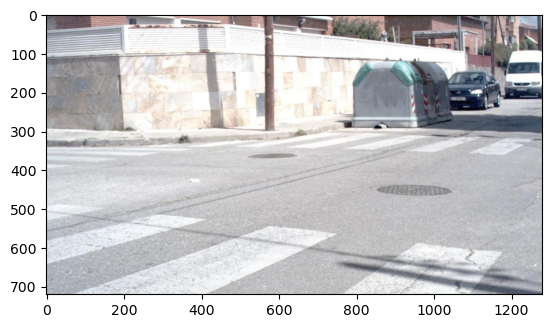

In [14]:
import matplotlib.pyplot as plt

# load test data
test_dataset = BIPEDv2(
    "../../resource/DexiNed/BIPEDv2/BIPED/edges/imgs/test/rgbr",
    "../../resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/test/rgbr"
)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],  
    std=[1/s for s in std]
)
# take one example
x, y = test_dataset[6]
plt.imshow(denormalize(x).permute(1,2,0))
plt.show()

In [15]:
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

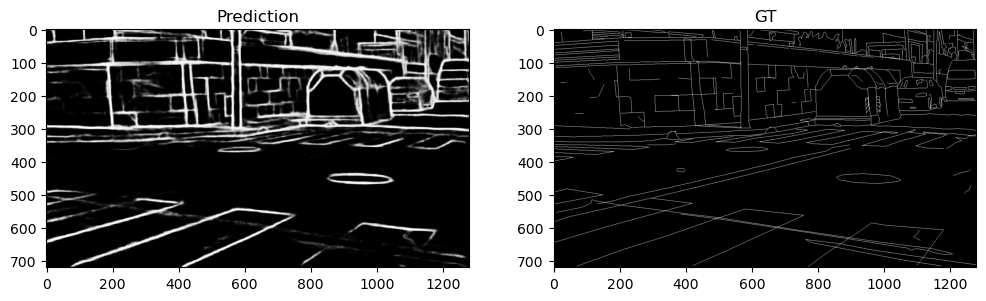

In [16]:
# display result
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
# fig.suptitle(img_index)
ax1.imshow(yhat, cmap="gray")
ax1.set_title("Prediction")
ax2.imshow(y, cmap="gray")
ax2.set_title("GT")
plt.show()

In [18]:
model.eval()
with torch.no_grad():
    model.to(device)
    prediction = model(x.unsqueeze(0).to(device))
    prediction = [p.to("cpu") for p in prediction]
    model.to('cpu')

In [20]:
len(prediction)

5